# Amazon Auto ARIMA Time Series Model 

I wanted to create a time series model that forecasted Amazon's stock prices according to my Robinhood dataset. I wanted to use some techniques that I have not used before. I got this time series modeling method from two Udemy time series courses and combined the two modeling techniques. Combining the models was not in my orginial plan but my model was not producing any results when I got to the forecasting section with my first process of choice, so combining the two strategies finally gave me some really good outcomes. 

The model versions that I used was the Simple Auto ARIMA Model and the Advanced Auto ARIMA Model methods. ARIMA stands for Auto Regressive Integrated Moving Average. This model is best when dealing with non-stationary data, which I had. Predicting the stock market will almost always produce non-stationary data and the ARIMA model will almost always be the best choice. The advantage of the Auto ARIMA model over a simple ARIMA model is the Auto ARIMA method automatically returns the best p, d, q without having to conduct multiple models to find the best fit. The p, d, and q stands for:

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

In the end, I decided to use the Advanced Auto ARIMA method because I wanted to compare and tweak different model parameters due to the fact that sometimes the Simple Auto ARIMA model can over look certain variables. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from pmdarima.arima import auto_arima
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore') 
import pandas.util.testing as tm
import seaborn as sns
sns.set()

I am going to load, clean and manipulate my data to prepare for EDA.

In [2]:
df1 = pd.read_csv('Robinhood_Master_v1.csv')
df1

,Unnamed: 0,Clean_Datetime,Clean_Datetime_PST,Close,High,Low,Open,OpenInt,Ticker,Vol,users_holding_first,users_holding_last,users_holding_max,users_holding_min
0,0,NaN,2019-09-23 08:00:00,51.8985,51.9595,51.8985,51.9595,0,IBA,374,22.0,22.0,22.0,22.0
1,1,NaN,2019-09-23 10:00:00,51.9400,52.0300,51.9400,52.0300,0,IBA,200,22.0,22.0,22.0,22.0
2,2,NaN,2019-09-23 11:00:00,51.9300,51.9300,51.9300,51.9300,0,IBA,100,22.0,22.0,22.0,22.0
3,3,NaN,2019-09-23 12:00:00,52.3100,52.3100,51.8500,52.0571,0,IBA,525,22.0,22.0,22.0,22.0
4,4,NaN,2019-09-23 13:00:00,52.2500,52.3000,52.2500,52.3000,0,IBA,400,22.0,22.0,22.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10419769,804,NaN,2020-07-17 08:00:00,1.9003,1.9297,1.9000,1.9273,0,ENTX,1400,250.0,241.0,250.0,241.0
10419770,805,NaN,2020-07-17 09:00:00,1.8764,1.8800,1.8600,1.8800,0,ENTX,4330,239.0,239.0,239.0,239.0
10419771,806,NaN,2020-07-17 10:00:00,1.8600,1.8800,1.8600,1.8600,0,ENTX,5150,239.0,236.0,239.0,236.0
10419772,807,NaN,2020-07-17 12:00:00,1.8900,1.8900,1.8600,1.8600,0,ENTX,3114,236.0,235.0,236.0,235.0


I am converting my data into datetime data and then filter it out to generate the end of day information for every day the stock market is open for each asset. The data was already indexed once before I downloaded it from Kaggle, and I was unable to reset it. I had to make a filter to create the datetime filter that I wanted.

In [3]:
df1[['Date','Time']] = df1.Clean_Datetime_PST.str.split(" ",expand=True,)
df2=df1.drop(columns=['Unnamed: 0', 'Clean_Datetime', 'OpenInt', 'Clean_Datetime_PST'])
df2

,Close,High,Low,Open,Ticker,Vol,users_holding_first,users_holding_last,users_holding_max,users_holding_min,Date,Time
0,51.8985,51.9595,51.8985,51.9595,IBA,374,22.0,22.0,22.0,22.0,2019-09-23,08:00:00
1,51.9400,52.0300,51.9400,52.0300,IBA,200,22.0,22.0,22.0,22.0,2019-09-23,10:00:00
2,51.9300,51.9300,51.9300,51.9300,IBA,100,22.0,22.0,22.0,22.0,2019-09-23,11:00:00
3,52.3100,52.3100,51.8500,52.0571,IBA,525,22.0,22.0,22.0,22.0,2019-09-23,12:00:00
4,52.2500,52.3000,52.2500,52.3000,IBA,400,22.0,22.0,22.0,22.0,2019-09-23,13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
10419769,1.9003,1.9297,1.9000,1.9273,ENTX,1400,250.0,241.0,250.0,241.0,2020-07-17,08:00:00
10419770,1.8764,1.8800,1.8600,1.8800,ENTX,4330,239.0,239.0,239.0,239.0,2020-07-17,09:00:00
10419771,1.8600,1.8800,1.8600,1.8600,ENTX,5150,239.0,236.0,239.0,236.0,2020-07-17,10:00:00
10419772,1.8900,1.8900,1.8600,1.8600,ENTX,3114,236.0,235.0,236.0,235.0,2020-07-17,12:00:00


In [4]:
filt = (df2['Time'] == '13:00:00')
day = df2[filt]

In [5]:
day['Date'] = pd.to_datetime(day.Date)
day.set_index('Date', inplace=True)

In [6]:
day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542405 entries, 2019-09-23 to 2020-07-17
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Close                1542405 non-null  float64
 1   High                 1542405 non-null  float64
 2   Low                  1542405 non-null  float64
 3   Open                 1542405 non-null  float64
 4   Ticker               1542405 non-null  object 
 5   Vol                  1542405 non-null  int64  
 6   users_holding_first  1289438 non-null  float64
 7   users_holding_last   1289438 non-null  float64
 8   users_holding_max    1289438 non-null  float64
 9   users_holding_min    1289438 non-null  float64
 10  Time                 1542405 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 141.2+ MB


In [7]:
day = day.fillna(method='bfill')
day

,Close,High,Low,Open,Ticker,Vol,users_holding_first,users_holding_last,users_holding_max,users_holding_min,Time
Date,,,,,,,,,,,
2019-09-23,52.25,52.30,52.250,52.3000,IBA,400,22.0,22.0,22.0,22.0,13:00:00
2019-09-24,52.51,52.68,52.500,52.5000,IBA,508,22.0,22.0,22.0,22.0,13:00:00
2019-09-25,52.62,52.62,52.415,52.6200,IBA,2618,22.0,22.0,22.0,22.0,13:00:00
2019-09-26,51.75,51.82,51.750,51.7877,IBA,1547,22.0,22.0,22.0,22.0,13:00:00
2019-09-27,53.76,53.76,53.080,53.0800,IBA,1809,22.0,22.0,22.0,22.0,13:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,1.84,1.88,1.800,1.8087,ENTX,120507,267.0,267.0,267.0,267.0,13:00:00
2020-07-14,1.79,1.79,1.775,1.7801,ENTX,4300,252.0,252.0,252.0,252.0,13:00:00
2020-07-15,1.91,1.94,1.900,1.9300,ENTX,13029,286.0,281.0,286.0,281.0,13:00:00


In [8]:
day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1542405 entries, 2019-09-23 to 2020-07-17
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Close                1542405 non-null  float64
 1   High                 1542405 non-null  float64
 2   Low                  1542405 non-null  float64
 3   Open                 1542405 non-null  float64
 4   Ticker               1542405 non-null  object 
 5   Vol                  1542405 non-null  int64  
 6   users_holding_first  1542405 non-null  float64
 7   users_holding_last   1542405 non-null  float64
 8   users_holding_max    1542405 non-null  float64
 9   users_holding_min    1542405 non-null  float64
 10  Time                 1542405 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 141.2+ MB


I again filter the data using a groupby method by combining the 'Date' column and the 'Close' column and generate the Tesla assets daily closing price mean. I again do the same thing for the max amount of daily users as well and plot them both.

In [166]:
filt = (day['Ticker'] == 'AMZN')
Amazon = day[filt]

In [167]:
Amazon

,Close,High,Low,Open,Ticker,Vol,users_holding_first,users_holding_last,users_holding_max,users_holding_min,Time
Date,,,,,,,,,,,
2019-09-23,1785.30,1792.70,1784.10,1790.32,AMZN,366379,116052.0,116052.0,116052.0,116052.0,13:00:00
2019-09-24,1741.61,1747.58,1735.55,1745.47,AMZN,637112,116612.0,116612.0,116612.0,116612.0,13:00:00
2019-09-25,1768.33,1773.00,1763.26,1764.03,AMZN,533712,116948.0,116948.0,116948.0,116948.0,13:00:00
2019-09-26,1740.12,1746.89,1736.50,1737.28,AMZN,311176,117468.0,117468.0,117468.0,117468.0,13:00:00
2019-09-27,1725.45,1727.64,1715.92,1716.15,AMZN,499621,117692.0,117692.0,117692.0,117692.0,13:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-13,3104.00,3228.24,3068.39,3228.24,AMZN,957947,357773.0,357773.0,357773.0,357773.0,13:00:00
2020-07-14,3084.00,3092.01,3006.45,3043.66,AMZN,549608,362181.0,362181.0,362181.0,362181.0,13:00:00
2020-07-15,3008.87,3031.50,3000.00,3026.22,AMZN,519083,366864.0,367492.0,367492.0,366864.0,13:00:00


In [168]:
Amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205 entries, 2019-09-23 to 2020-07-17
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                205 non-null    float64
 1   High                 205 non-null    float64
 2   Low                  205 non-null    float64
 3   Open                 205 non-null    float64
 4   Ticker               205 non-null    object 
 5   Vol                  205 non-null    int64  
 6   users_holding_first  205 non-null    float64
 7   users_holding_last   205 non-null    float64
 8   users_holding_max    205 non-null    float64
 9   users_holding_min    205 non-null    float64
 10  Time                 205 non-null    object 
dtypes: float64(8), int64(1), object(2)
memory usage: 19.2+ KB


In [169]:
Amazon2 = Amazon.groupby('Date').aggregate({'Close':'mean'})
Amazon2

,Close
Date,
2019-09-23,1785.30
2019-09-24,1741.61
2019-09-25,1768.33
2019-09-26,1740.12
2019-09-27,1725.45
...,...
2020-07-13,3104.00
2020-07-14,3084.00
2020-07-15,3008.87


In [170]:
users = Amazon.groupby('Date').aggregate({'users_holding_max':'mean'})
users

,users_holding_max
Date,
2019-09-23,116052.0
2019-09-24,116612.0
2019-09-25,116948.0
2019-09-26,117468.0
2019-09-27,117692.0
...,...
2020-07-13,357773.0
2020-07-14,362181.0
2020-07-15,367492.0


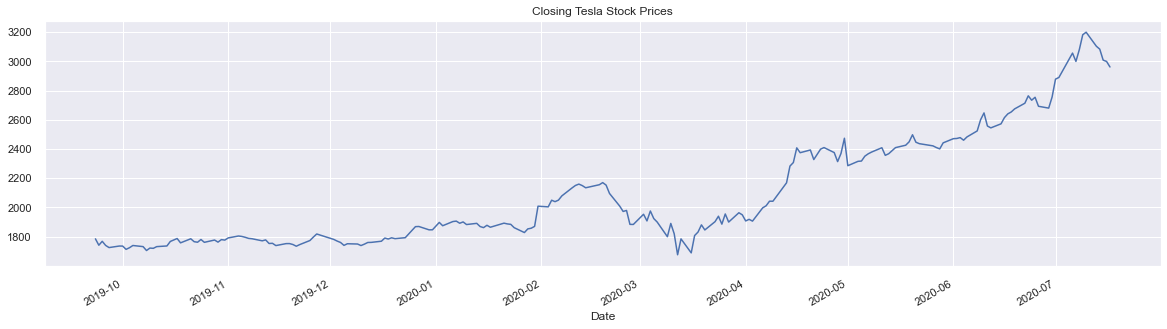

In [171]:
Amazon2.Close.plot(figsize=(20,5), title='Closing Tesla Stock Prices')

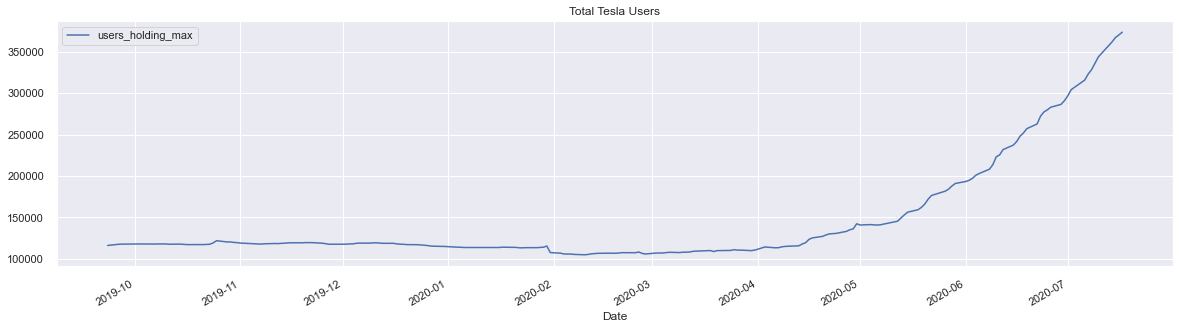

In [172]:
users.plot(figsize=(20,5), title='Total Tesla Users')

I am now going to run the Dickey-Fuller test to check to see if my data is stationary. The results show that it is not because the first value has to be less than the three critical values at the bottom (1%, 5%, 10%), and the p-value, the second value, is not in the >=0.05 range. I am going to convert the data into returns to get my data stationary.

In [173]:
sts.adfuller(Amazon2.Close)

(0.3939818141807283,
 0.9812684830836589,
 2,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 2000.7781130984656)

In [174]:
Amazon2['returns'] = Amazon2.Close.pct_change(1).mul(100)
Amazon2 = Amazon2.iloc[1:]
Amazon2['returns2'] = Amazon2.Close.pct_change(1).mul(100)
Amazon2

,Close,returns,returns2
Date,,,
2019-09-24,1741.61,-2.447208,NaN
2019-09-25,1768.33,1.534213,1.534213
2019-09-26,1740.12,-1.595290,-1.595290
2019-09-27,1725.45,-0.843045,-0.843045
2019-09-30,1735.91,0.606219,0.606219
...,...,...,...
2020-07-13,3104.00,-3.000000,-3.000000
2020-07-14,3084.00,-0.644330,-0.644330
2020-07-15,3008.87,-2.436122,-2.436122


Looking at my data now, this shows that my data is now stationary! I am also going to check the ACF and PACF.

In [175]:
sts.adfuller(Amazon2.returns)

(-5.574398178945019,
 1.4431103176289627e-06,
 7,
 196,
 {'1%': -3.464161278384219,
  '5%': -2.876401960790147,
  '10%': -2.5746921001665974},
 828.4692276485418)

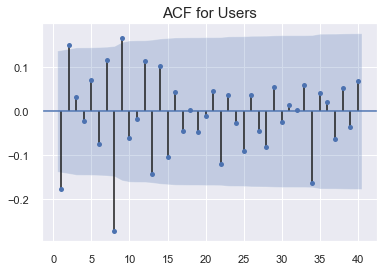

In [176]:
sgt.plot_acf(Amazon2.returns, lags = 40, zero = False)
plt.title('ACF for Users', size = 15)
plt.show()

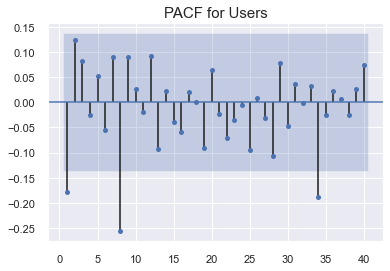

In [177]:
sgt.plot_pacf(Amazon2.returns, lags = 40, zero = False)
plt.title('PACF for Users', size = 15)
plt.show()

I am now going to split my test and train sets for my modeling.

In [178]:
size = int(len(Amazon2)*0.8)
df = Amazon2.iloc[:size] 
df_test = Amazon2.iloc[size:]

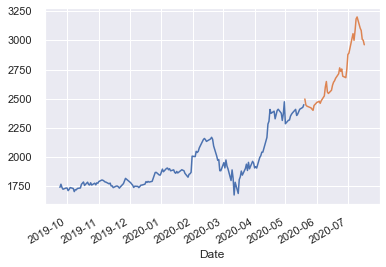

In [340]:
df.Close.plot()
df_test.Close.plot()

## Simple Auto ARIMA

Even though I created returns from the stock prices and made my data stationary, I am going to use a simple Auto ARIMA model and also an Advanced Auto ARIMA model to test to see which model produces the best forecasting results. These models are best for non-stationary data modeling and usually returns better forecasting results.

In [180]:
model_auto = auto_arima(df.Close)

In [181]:
model_auto

ARIMA(order=(1, 1, 0), scoring_args={})

In [182]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  163
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -840.018
Date:                Tue, 08 Sep 2020   AIC                           1686.035
Time:                        23:10:02   BIC                           1695.298
Sample:                             0   HQIC                          1689.796
                                - 163                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.1492      3.447      1.494      0.135      -1.607      11.905
ar.L1         -0.1994      0.051     -3.920      0.000      -0.299      -0.100
sigma2      1866.4236    128.328     14.544      0.000    1614.906    2117.942
===================================================================================
Ljung-Box (Q):                       48.01   Jarque-Bera (JB):                73.52
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):              13.37   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [353]:
prediction = pd.DataFrame(model_auto.predict(n_periods = 41), index=df_test.Close.index)
prediction.columns = ['predicted_stock_price']
prediction.head()

,predicted_stock_price
Date,
2020-05-20,2449.877894
2020-05-21,2454.917819
2020-05-22,2459.061809
2020-05-26,2463.384493
2020-05-27,2467.671537


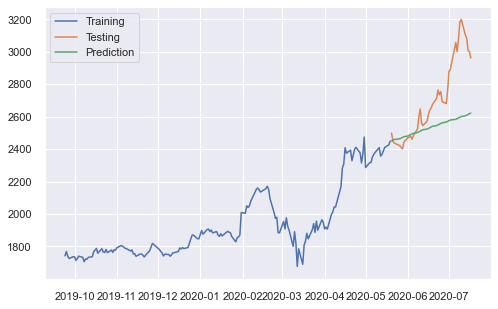

In [354]:
plt.figure(figsize=(8,5))
plt.plot(df.Close, label = 'Training')
plt.plot(df_test.Close, label = 'Testing')
plt.plot(prediction, label = 'Prediction')
plt.legend(loc = 'Left corner')
plt.show()

Text(0.5, 1.0, 'Predicted Amazon Stock Prices vs. Test Data')

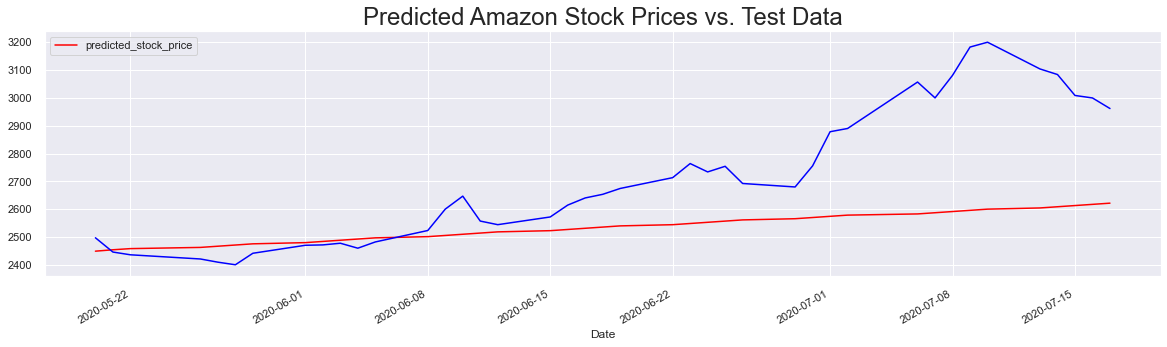

In [355]:
prediction.plot(figsize = (20,5), color = 'red')
df_test.Close.plot(color = 'blue')
plt.title('Predicted Amazon Stock Prices vs. Test Data', size = 24)

I am going to calculate the r2 score to show just how accurate my prediction model is. -0.158 is not accurate at all. You want you score to be as close to 1.0 as you can get. Anything 0.70+ is usually considered substantial. I am going to build an advanced auto ARIMA model next to see if that will give me better results.

In [356]:
df_test['predicted_stock_price'] = prediction
r2_score(df_test.Close, df_test.predicted_stock_price)

-0.15836897303755193

## Advanced Auto ARIMA

In [348]:
model_auto2 = auto_arima(df.Close, m = 2,
                       max_order = None, max_p = 2, max_q =2, max_d = 1, max_P = 2, max_Q = 2, max_D = 1,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, seasonal = True, error_action='ignore', trace=True, surpress_warnings=True, stepwise=True, trend = 'ct', information_criterion = 'oob',
                       out_of_sample_size = int(len(Amazon2)*0.2))

Performing stepwise search to minimize oob
 ARIMA(1,1,1)(1,0,1)[2] intercept   : OOB=153274.179, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : OOB=147543.929, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : OOB=153937.867, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : OOB=159018.442, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[2]             : OOB=147543.929, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[2] intercept   : OOB=147384.032, Time=0.09 sec
 ARIMA(0,1,0)(2,0,0)[2] intercept   : OOB=155082.097, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[2] intercept   : OOB=135057.463, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[2] intercept   : OOB=145756.637, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1)[2] intercept   : OOB=140420.506, Time=0.30 sec
 ARIMA(0,1,0)(1,0,2)[2] intercept   : OOB=134307.143, Time=0.27 sec
 ARIMA(0,1,0)(0,0,2)[2] intercept   : OOB=156066.491, Time=0.12 sec
 ARIMA(0,1,0)(2,0,2)[2] intercept   : OOB=135090.155, Time=0.43 sec
 ARIMA(1,1,0)(1,0,2)[2] intercept   : OOB=152895.631, Time=0.34 sec
 ARIM

In [357]:
prediction2 = pd.DataFrame(model_auto2.predict(n_periods = 41), index=df_test.Close.index)
prediction2.columns = ['predicted_stock_price']
prediction2.head()

,predicted_stock_price
Date,
2020-05-20,2459.712767
2020-05-21,2470.940485
2020-05-22,2480.954507
2020-05-26,2491.061614
2020-05-27,2501.141673


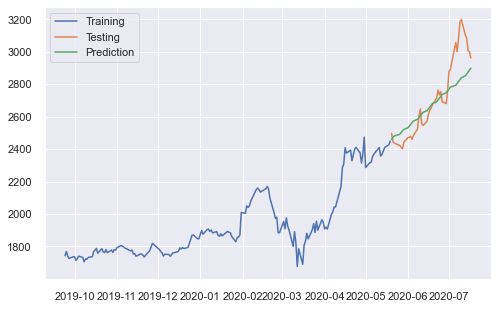

In [358]:
plt.figure(figsize=(8,5))
plt.plot(df.Close, label = 'Training')
plt.plot(df_test.Close, label = 'Testing')
plt.plot(prediction2, label = 'Prediction')
plt.legend(loc = 'Left corner')
plt.show()

Text(0.5, 1.0, 'Predicted Amazon Stock Prices vs. Test Data')

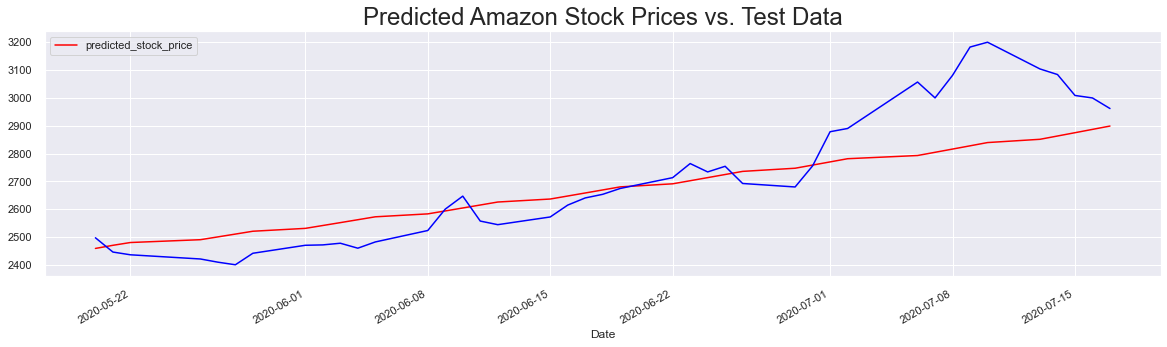

In [359]:
prediction2.plot(figsize = (20,5), color = 'red')
df_test.Close.plot(color = 'blue')
plt.title('Predicted Amazon Stock Prices vs. Test Data', size = 24)

This model did a lot better! It returned an r2 score of 0.70 which means it is a substantial model. I think my results would have been higher if my training data did not have the COVID 19 stock market crash included during the months of March and April 2020. 

In [360]:
from sklearn.metrics import r2_score
df_test['predicted_stock_price'] = prediction2
r2_score(df_test.Close, df_test.predicted_stock_price)

0.7006142667306581

## Conclusion 

Using the Advanced Auto ARIMA model produced a far more accurate forecasting model than the simple Auto ARIMA model due to the ability of customizing the parameters. My r2 score went from a -0.15836897303755193 to a 0.7006142667306581. Or a -0.16 to a 0.70. It went from not accurate at all to being substantially accurate. 

I also believe that my model would have been a lot more accurate if it did not have the unforeseen COVID 19 stock market crash in March - April 2020. Trying to create accuracy with a recession built into the data makes things a lot harder since the forecasting values are determined by the past. I want to keep tweaking my model with the different advanced parameter options as well to see if I can  get my model to start to predict volatility. 